### Dual moving average

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
yf.pdr_override()

1. This code will first check whether the `goog_data_large.pkl` file exists. If the file does not exist, we will fetch the `GOOG` data from Yahoo finance:

In [3]:
def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        # df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df = data.get_data_yahoo('GOOG', start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [4]:
goog_data=load_financial_data(
    start_date='2014-01-01',
    end_date = '2018-01-01',
    output_file='goog_data.pkl')

goog_data.head()

File data found...reading GOOG data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218


2. Next, as shown in the preceding code, we will create a `double_moving_average` function with parameters fixing the size of the two moving averages returning a data frame:

* `short_mavg`: Short-term moving average values
* `long_mavg`: Long-term moving average values
* `signal`: True if the short-term moving average is higher than the long-term moving average
* `orders`: `1` for the buy order, and `-1` for the sell order:

In [5]:
def double_moving_average(financial_data, short_window, long_window):
    signals = pd.DataFrame(index=financial_data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = financial_data['Close'].\
        rolling(window=short_window,
                min_periods=1, center=False).mean()
    signals['long_mavg'] = financial_data['Close'].\
        rolling(window=long_window,
                min_periods=1, center=False).mean()
    signals['signal'][short_window:] =\
        np.where(signals['short_mavg'][short_window:]
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['orders'] = signals['signal'].diff()
    return signals

ts=double_moving_average(goog_data,20,100)
ts.tail()

,signal,short_mavg,long_mavg,orders
Date,,,,
2017-12-22,1.0,52.042750,48.949775,0.0
2017-12-26,1.0,52.049075,49.016320,0.0
2017-12-27,1.0,52.053975,49.077025,0.0
2017-12-28,1.0,52.120175,49.136415,0.0
2017-12-29,1.0,52.182650,49.196220,0.0


The code will build the data frame, `ts`:
* This data frame will contain the signal column storing the signal of going long (value 1) and going short (value 0)
* The column `orders` will contain the side of the orders (buy or sell)

3. We will now write the code to display the curve representing the orders for the dual moving strategy:

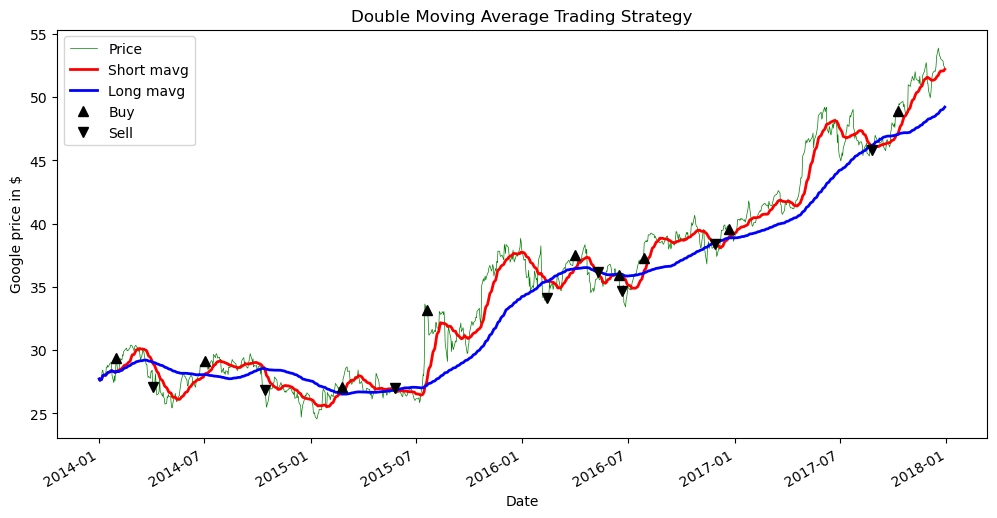

In [6]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["short_mavg"].plot(ax=ax1, color='r', lw=2.)
ts["long_mavg"].plot(ax=ax1, color='b', lw=2.)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

plt.legend(["Price","Short mavg","Long mavg","Buy","Sell"])
plt.title("Double Moving Average Trading Strategy")

plt.show()

The plot represents the `GOOG` prices and the two moving averages associated with this price. Each order is represented by an arrow.

### Naive trading strategy

In this section, we will implement a naive strategy based on the number of times a price increases or decreases. This strategy is based on the historical price momentum. Let's have a look at the code:

In [7]:
def naive_momentum_trading(financial_data, nb_conseq_days):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    cons_day=0
    prior_price=0
    init=True
    for k in range(len(financial_data['Adj Close'])):
        price=financial_data['Adj Close'][k]
        if init:
            prior_price=price
            init=False
        elif price>prior_price:
            if cons_day<0:
                cons_day=0
            cons_day+=1
        elif price<prior_price:
            if cons_day>0:
                cons_day=0
            cons_day-=1
        if cons_day==nb_conseq_days:
            signals['orders'][k]=1
        elif cons_day == -nb_conseq_days:
            signals['orders'][k]=-1

    return signals

ts=naive_momentum_trading(goog_data, 5)
ts.tail()

,orders
Date,
2017-12-22,0
2017-12-26,0
2017-12-27,0
2017-12-28,0
2017-12-29,0


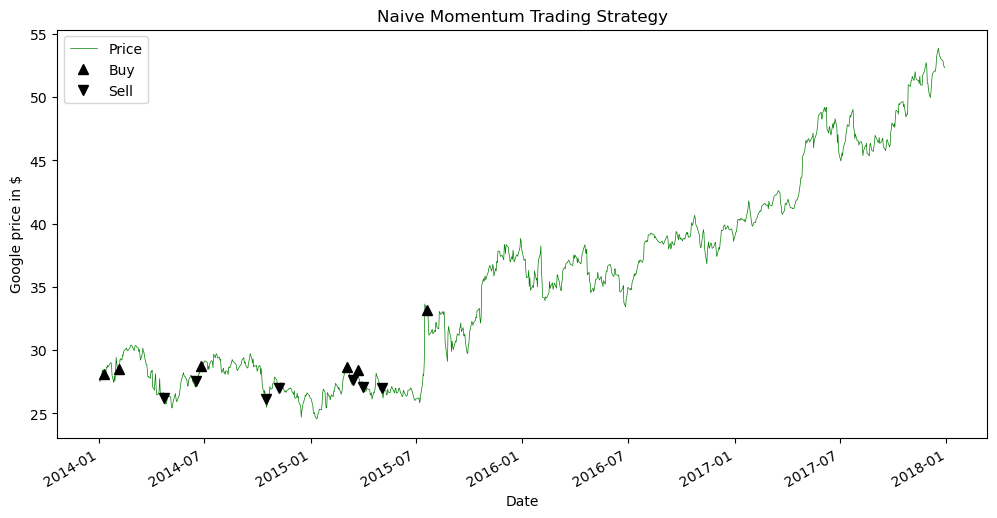

In [8]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1],
         'v', markersize=7, color='k')

plt.legend(["Price","Buy","Sell"])
plt.title("Naive Momentum Trading Strategy")

plt.show()

### Turtle strategy

In this more advanced trading strategy, we are going to create a long signal when the price reaches the highest price for the last `window_size` days (in this example, we will choose 50):

In [9]:
def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    # window_size-days high
    signals['high'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).max()
    # window_size-days low
    signals['low'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).min()
    # window_size-days mean
    signals['avg'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).mean()

    # entry rule : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day

    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    #exit rule : the stock price crosses the mean of past window_size days.

    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg

    init=True
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

ts=turtle_trading(goog_data, 50)
ts.tail()

,orders,high,low,avg,long_entry,short_entry,long_exit,short_exit
Date,,,,,,,,
2017-12-22,0,53.856998,48.422501,51.11769,False,False,False,True
2017-12-26,0,53.856998,48.422501,51.18998,False,False,False,True
2017-12-27,0,53.856998,48.422501,51.25704,False,False,False,True
2017-12-28,0,53.856998,48.422501,51.31441,False,False,False,True
2017-12-29,0,53.856998,48.422501,51.37037,False,False,False,True


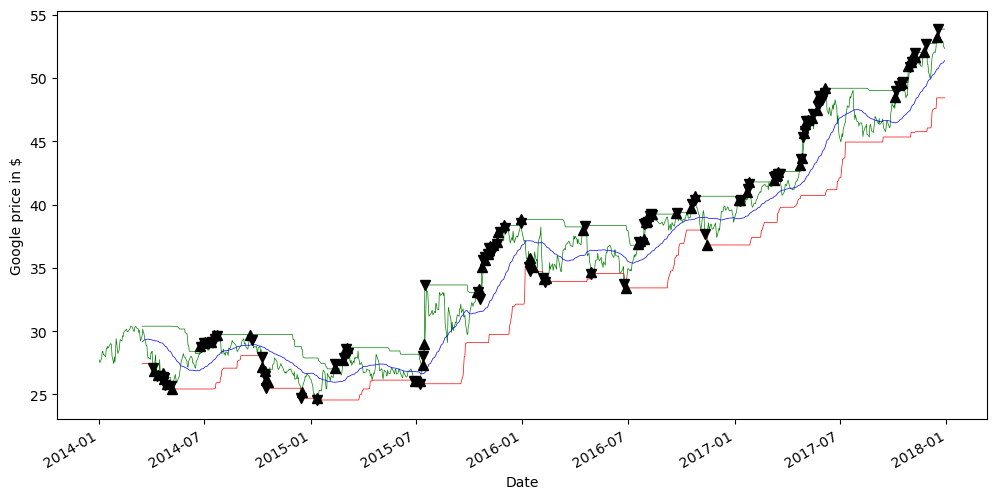

In [10]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)


ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

plt.show()

### Creating trading strategies that operate on linearly correlated groups of trading instruments

1. Let's begin by creating a function establishing cointegration between pairs, as shown in the following code. This function takes as inputs a list of financial instruments and calculates the cointegration values of these symbols. The values are stored in a matrix. We will use this matrix to display a heatmap:

In [11]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

2. Next, as shown in the code, we will load the financial data by using the panda data reader. This time, we load many symbols at the same time. In this example, we use SPY (this symbol reflects market movement), `APPL` (technology), `ADBE` (technology), `LUV` (airlines), `MSFT` (technology), `SKYW` (airline industry), `QCOM` (technology), `HPQ` (technology), `JNPR` (technology), `AMD` (technology), and `IBM` (technology).

    Since the goal of this trading strategy is to find co-integrated symbols, we narrow down the search space according to industry. This function will load the data of a file from the Yahoo finance website if the data is not in the `multi_data_large.pkl` file:

In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from statsmodels.tsa.stattools import coint
import seaborn

In [13]:
symbolsIds = ['SPY','AAPL','ADBE','LUV','MSFT','SKYW','QCOM', 'HPQ','JNPR','AMD','IBM']

In [14]:
def load_financial_data(symbols, start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading symbols data')
    except FileNotFoundError:
        print('File not found...downloading the symbols data')
        # df = data.DataReader(symbols, 'yahoo', start_date, end_date)
        df = data.get_data_yahoo(symbols, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [15]:
multi_data=load_financial_data(symbolsIds,start_date='2001-01-01',
                               end_date = '2018-01-01',
                               output_file='multi_data_large.pkl')

File data found...reading symbols data


3. After we call the load_financial_data function, we will then call the `find_cointegrated_pairs` function, as shown in the following code:

In [16]:
pvalues, pairs = find_cointegrated_pairs(multi_data['Adj Close'])

4. We will use the `seaborn` package to draw the heatmap. The code calls the `heatmap` function from the `seaborn` package. Heatmap will use the list of symbols on the *x* and *y* axes. The last argument will mask the p-values higher than `0.98`:

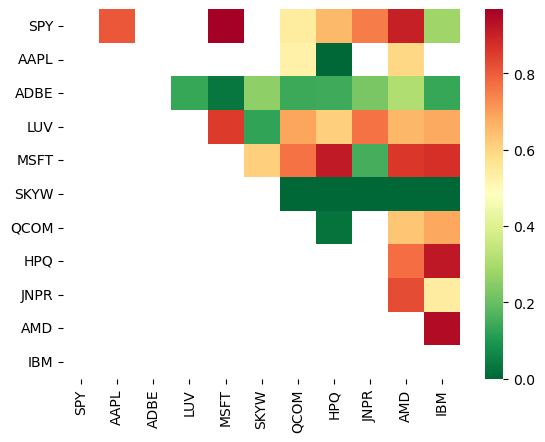

In [17]:
seaborn.heatmap(pvalues, xticklabels=symbolsIds,
                yticklabels=symbolsIds, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()

This code will return the above map as an output. This map shows the p-values of the return of the coin:

* If a p-value is lower than 0.02, this means the null hypothesis is rejected.
* This means that the two series of prices corresponding to two different symbols can be co-integrated.
* This means that the two symbols will keep the same spread on average. On the heatmap, we observe that the following symbols have p-values lower than 0.02:

This screenshot represents the heatmap measuring the cointegration between a pair of symbols. If it is red, this means that the p-value is 1, which means that the null hypothesis is not rejected. Therefore, there is no significant evidence that the pair of symbols is co-integrated. After selecting the pairs we will use for trading, let's focus on how to trade these pairs of symbols.

5. First, let's create a pair of symbols artificially to get an idea of how to trade. We will use the following libraries:

In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

6. As shown in the code, let's create a symbol return that we will call `Symbol1`. The value of the `Symbol1` price starts from a value of 10 and, every day, it will vary based on a random return (following a normal distribution). We will draw the price values by using the function plot of the `matplotlib.pyplot` package:

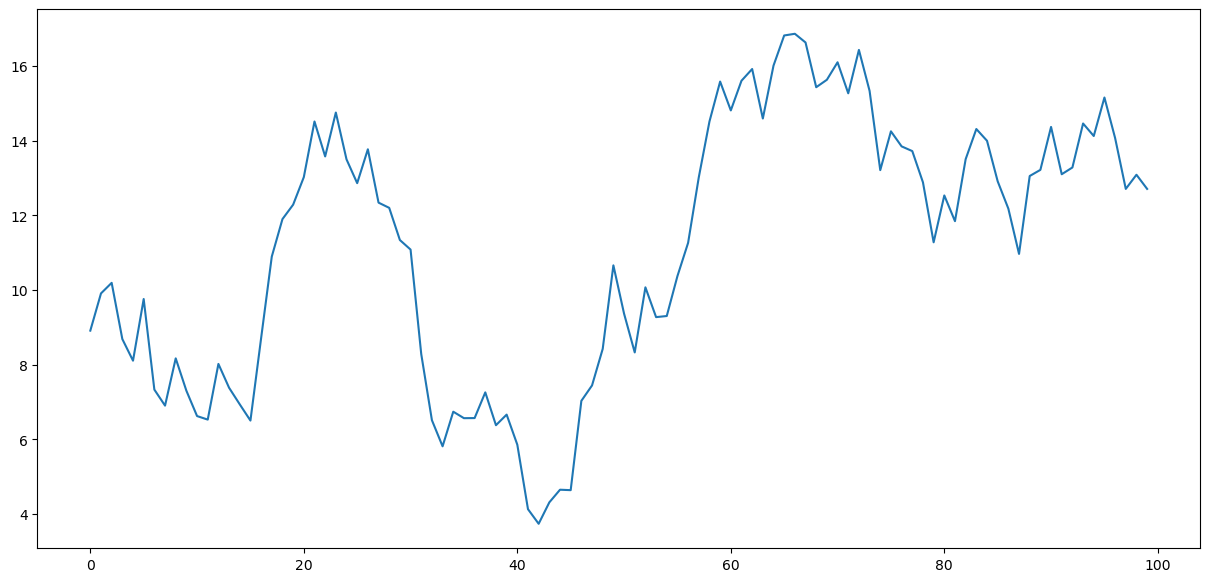

In [19]:
# Set a seed value to make the experience reproducible
np.random.seed(123)
# Generate Symbol1 daily returns
Symbol1_returns = np.random.normal(0, 1, 100)
# Create a series for Symbol1 prices
Symbol1_prices = pd.Series(np.cumsum(Symbol1_returns), name='Symbol1') + 10
Symbol1_prices.plot(figsize=(15,7))
plt.show()

7. We build the `Symbol2` prices based on the behavior of the `Symbol1` prices, as shown in the code. In addition to copying the behavior of `Symbol1`, we will add noises. The noise is a random value following a normal distribution. The introduction of this noise is designed to mimic market fluctuations. It changes the spread value between the two symbol prices:

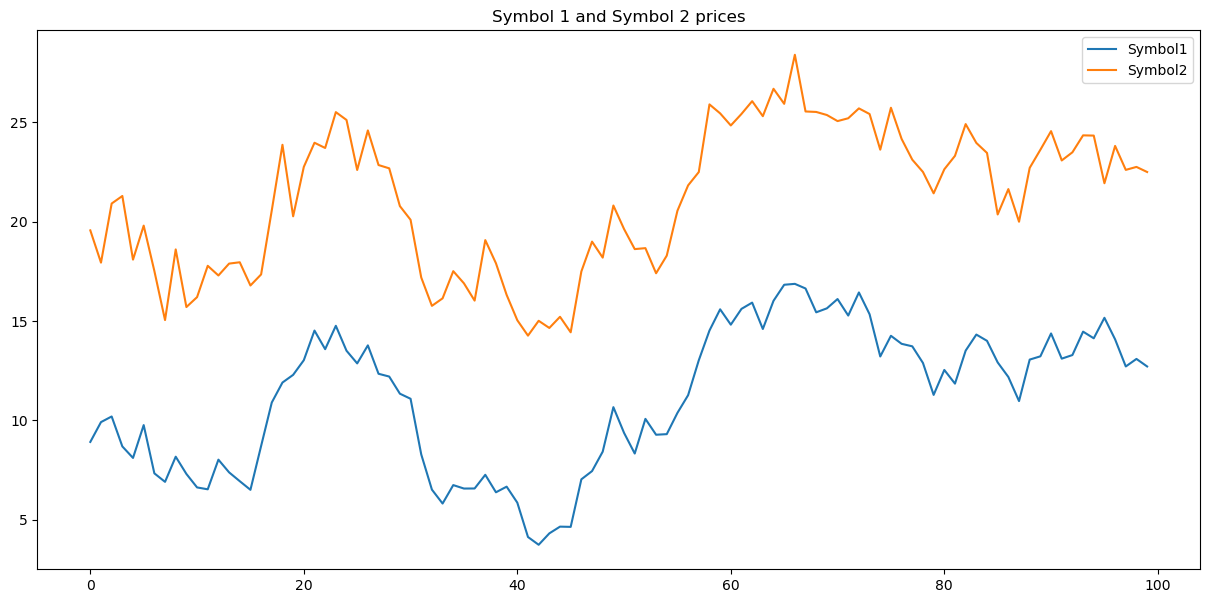

In [20]:
# Create a series for Symbol2 prices
# We will copy the Symbol1 behavior
noise = np.random.normal(0, 1, 100)
Symbol2_prices = Symbol1_prices + 10 + noise
Symbol2_prices.name = 'Symbol2'
plt.title("Symbol 1 and Symbol 2 prices")
Symbol1_prices.plot(figsize=(15,7))
Symbol2_prices.plot(figsize=(15,7))
plt.legend()
plt.show()

8. In the code, we will check the cointegration between the two symbols by using the `coint` function. This takes two lists/series of values and performs a test to check whether the two series are co-integrated:

In [21]:
score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)

In the code, pvalue contains the p-score. Its value is 10-13, which means that we can reject the null hypothesis. Therefore, these two symbols are co-integrated.

9. We will define the `zscore` function. This function returns how far a piece of data is from the population mean. This will help us to choose the direction of trading. If the return value of this function is positive, this means that the symbol price is higher than the average price value. Therefore, its price is expected to go down or the paired symbol value will go up. In this case, we will want to short this symbol and long the other one. The code implements the `zscore` function:

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

10. We will use the ratio between the two symbol prices. We will need to set the threshold that defines when a given price is far off the mean price value. For that, we will need to use specific values for a given symbol. If we have many symbols we want to trade with, this will imply that this analysis be performed for all the symbols. Since we want to avoid this tedious work, we are going to normalize this study by analyzing the ratio of the two prices instead. As a result, we calculate the ratios of the Symbol 1 price against the Symbol 2 price. Let's have a look at the code:

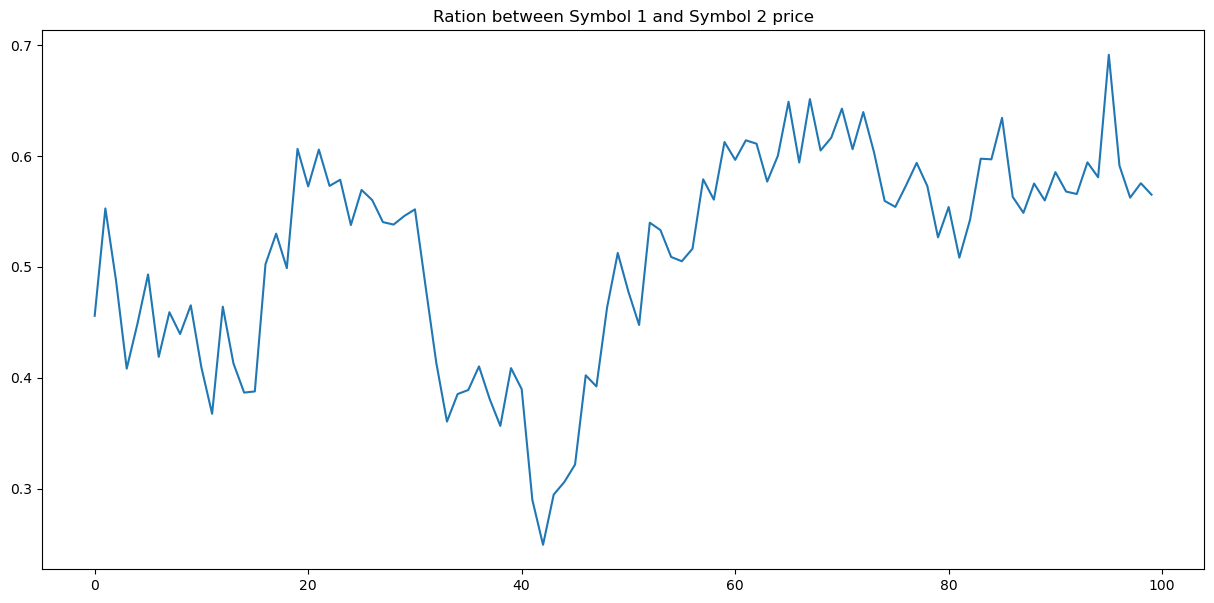

In [23]:
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ration between Symbol 1 and Symbol 2 price")
ratios.plot(figsize=(15,7))
plt.show()

11. Let's draw the chart showing when we will place orders with the following code:

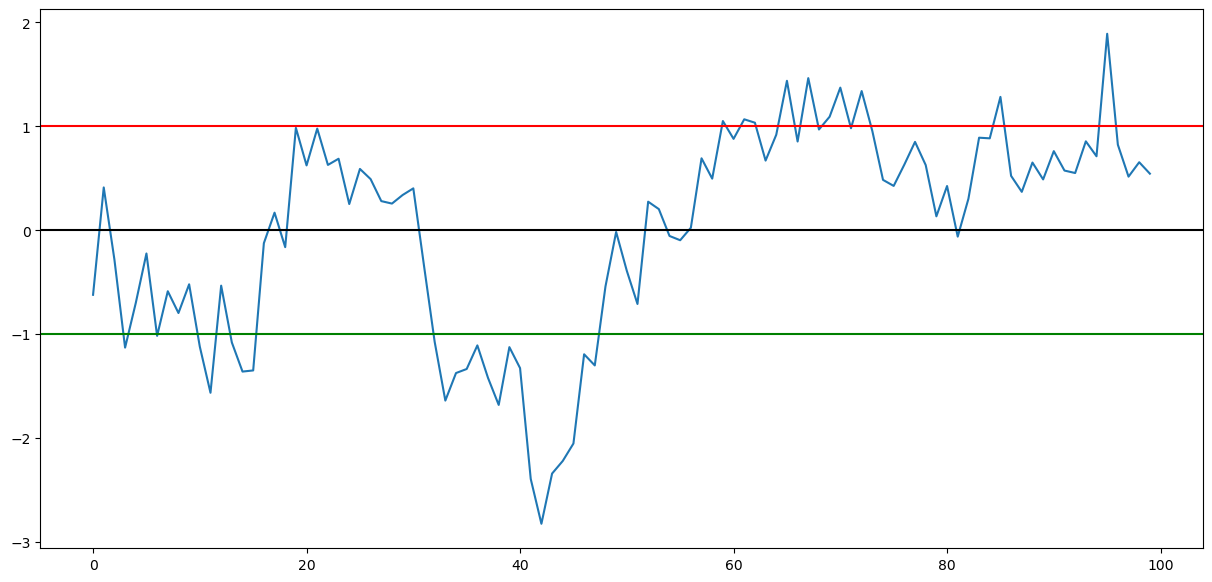

In [24]:
train = ratios[:75]
test = ratios[75:]

# plt.axhline(ratios.mean())
# plt.legend([' Ratio'])
# plt.show()

zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

This code will return the following output. The curve demonstrates the following:
* The Z-score evolution with horizontal lines at -1 (green), +1 (red), and the average of Z-score (black).
* The average of Z-score is 0.
* When the Z-score reaches -1 or +1, we will use this event as a trading signal. The values +1 and -1 are arbitrary values.
* It should be set depending on the study we will run in order to create this trading strategy:

12. Every time the Z-score reaches one of the thresholds, we have a trading signal. As shown in the code, we will present a graph, each time we go long for Symbol 1 with a green marker, and each time we go short with a red marker:

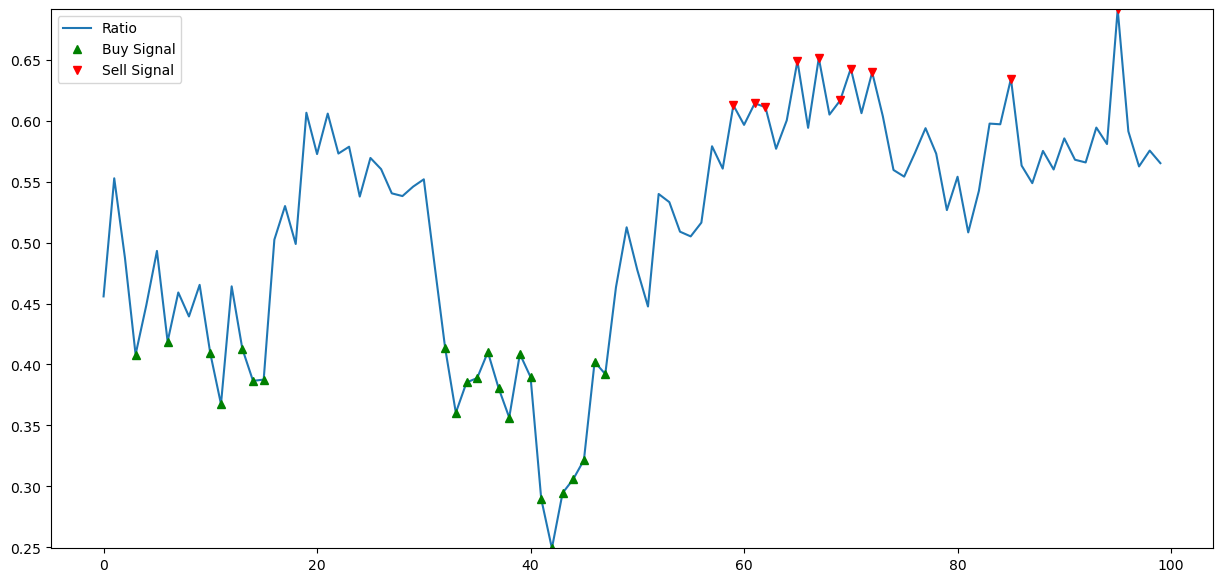

In [25]:
ratios.plot(figsize=(15,7))
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

In this example, going long for Symbol 1 means that we will send a buy order for Symbol 1, while sending a sell order for Symbol 2 concurrently.

13. Next, we will write the following code, which represents the buy and sell order for each symbol:

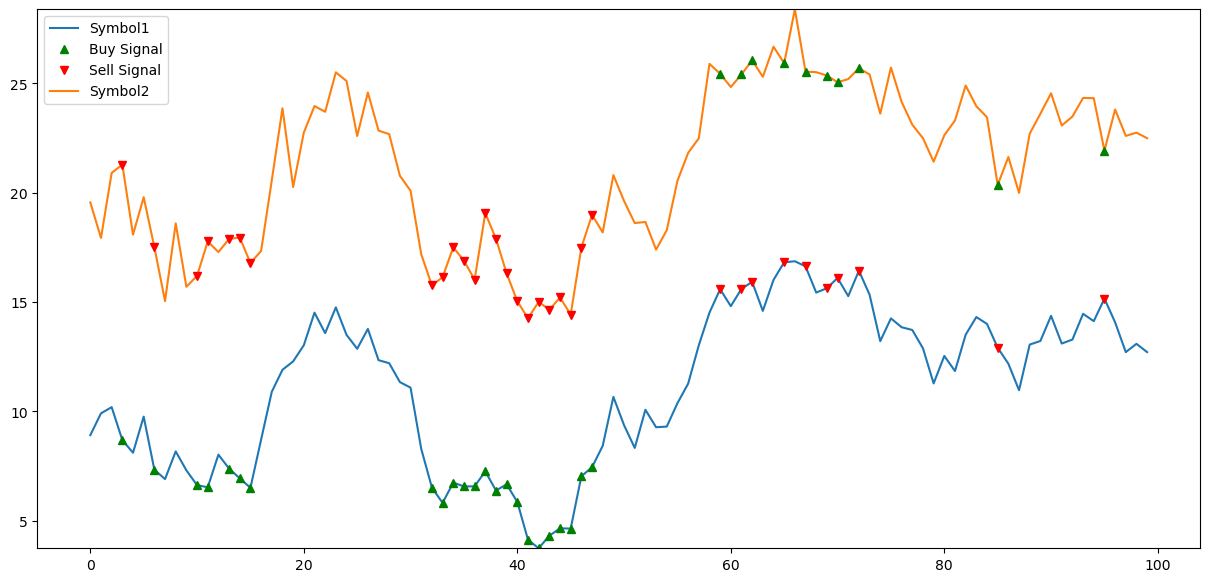

In [26]:
symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

Symbol1_prices.plot(figsize=(15,7))
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

Symbol2_prices.plot(figsize=(15,7))
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

14. We will use `MSFT` and `JNPR` to implement the strategy based on real symbols. We will replace the code to build Symbol 1 and Symbol 2 with the following code. The following code will get the real prices for `MSFT` and `JNPR`:

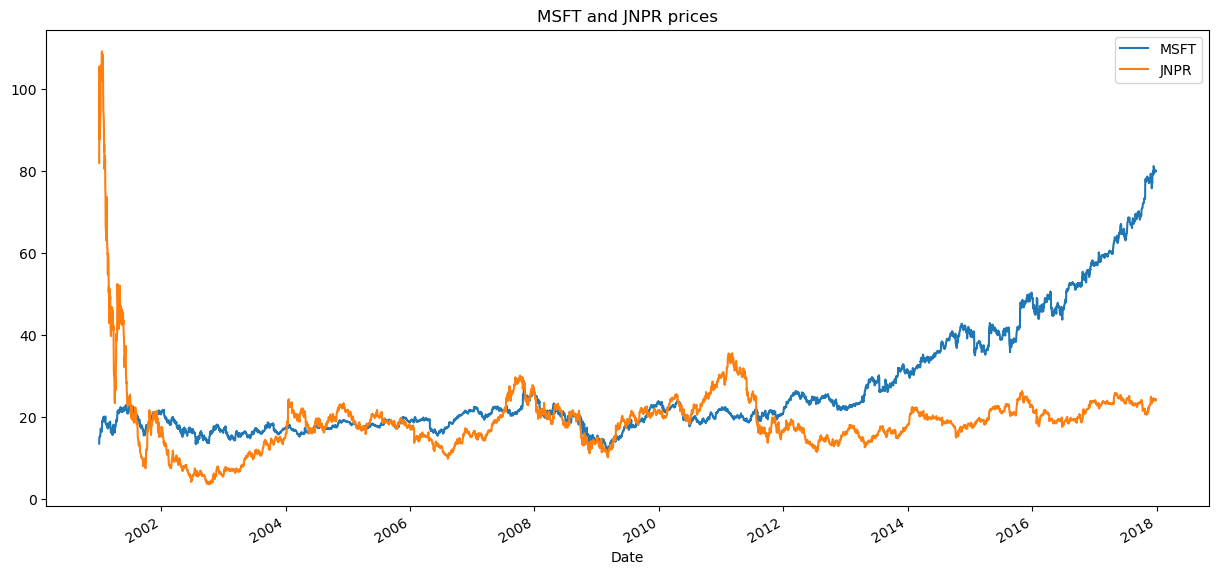

In [27]:
Symbol1_prices = multi_data['Adj Close']['MSFT']
Symbol1_prices.name = 'MSFT'
Symbol1_prices.plot(figsize=(15,7))

Symbol2_prices = multi_data['Adj Close']['JNPR']
Symbol2_prices.name = 'JNPR'
Symbol2_prices.plot(figsize=(15,7))

plt.title("MSFT and JNPR prices")
plt.legend()
plt.show()

1.0


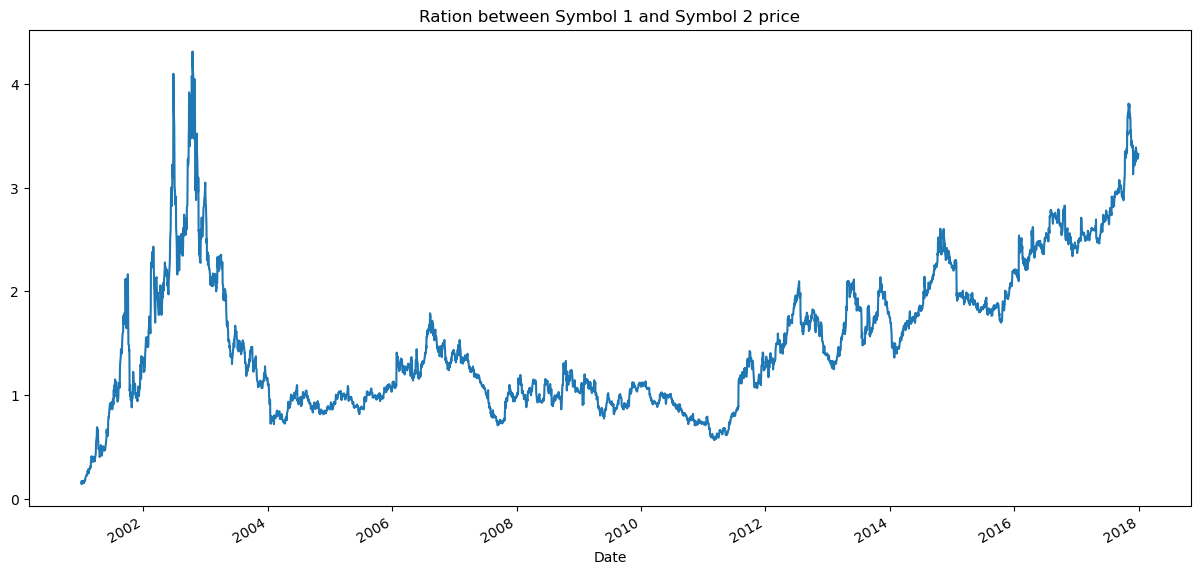

In [28]:
score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)
print(pvalue)
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ration between Symbol 1 and Symbol 2 price")

ratios.plot(figsize=(15,7))
plt.show()

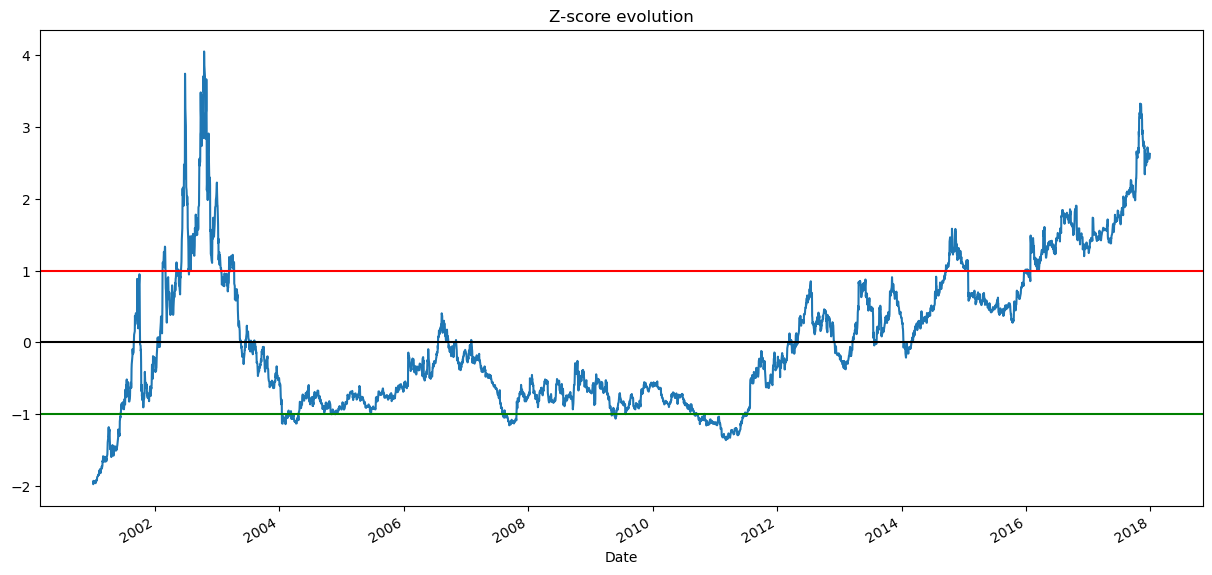

In [29]:
zscore(ratios).plot(figsize=(15,7))
plt.title("Z-score evolution")
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

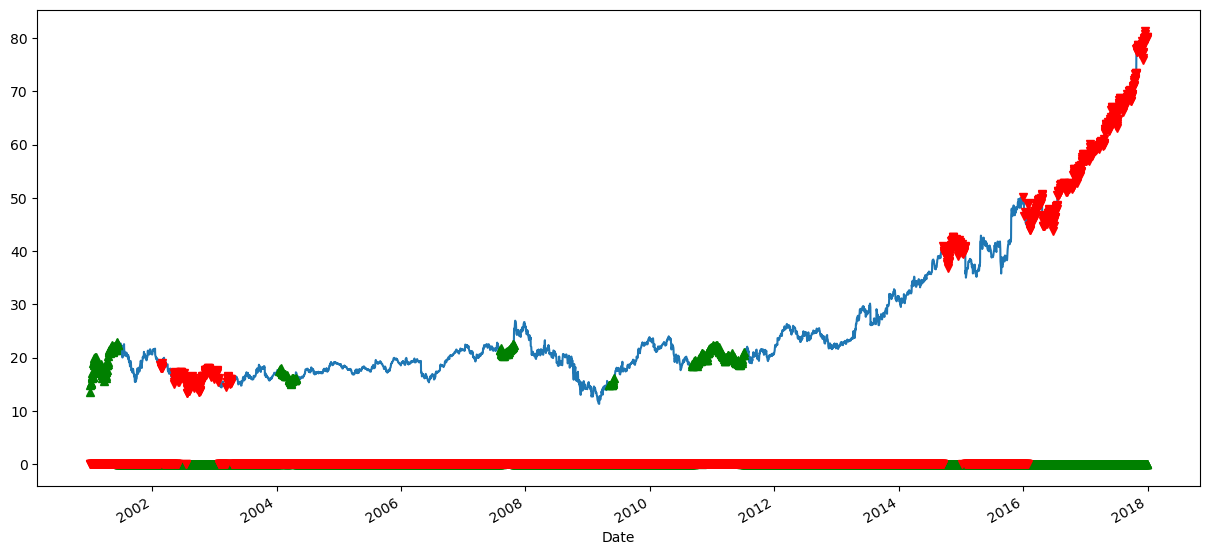

In [30]:
symbol1_buy = Symbol1_prices.copy()
symbol1_sell = Symbol1_prices.copy()
symbol2_buy = Symbol2_prices.copy()
symbol2_sell = Symbol2_prices.copy()

Symbol1_prices.plot(figsize=(15,7))
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^", figsize=(15,7))
symbol1_sell.plot(color="r", linestyle="None", marker="v", figsize=(15,7))
plt.show()

15. We will create a data frame, `pair_correlation_trading_strategy`, in the code. This contains information relating to orders and position and we will use this data frame to calculate the performance of this pair correlation trading strategy:

In [31]:
pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price'] = Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(len(Symbol1_prices))

16. We will limit the number of orders by reducing the position to one share. This can be a long or short position. For a given symbol, when we have a long position, a sell order is the only one that is allowed. When we have a short position, a buy order is the only one that is allowed. When we have no position, we can either go long (by buying) or go short (by selling). We will store the price we use to send the orders. For the paired symbol, we will do the opposite. When we sell Symbol 1, we will buy Symbol 2, and vice versa:

In [32]:
position=0
for i in range(len(Symbol1_prices)):
    s1price=Symbol1_prices[i]
    s2price=Symbol2_prices[i]
    if not position and symbol1_buy[i]!=0:
        pair_correlation_trading_strategy['symbol1_buy'][i]=s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position=1
    elif not position and symbol1_sell[i]!=0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = -1
    elif position==-1 and (symbol1_sell[i]==0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 0
    elif position==1 and (symbol1_buy[i] == 0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = 0

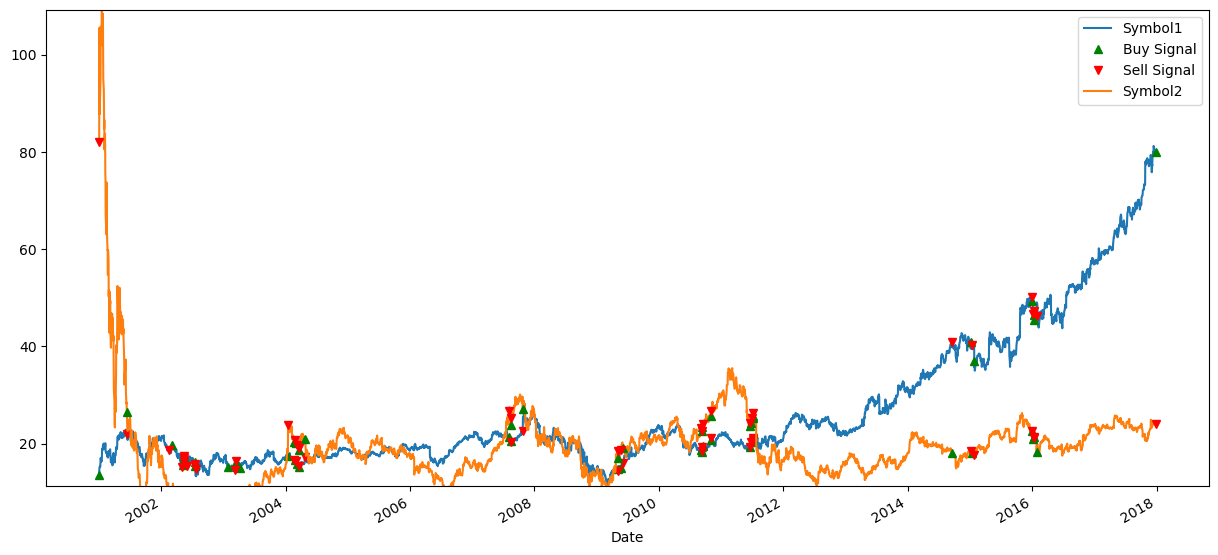

In [33]:
Symbol1_prices.plot(figsize=(15,7))
pair_correlation_trading_strategy['symbol1_buy'].plot(color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol1_sell'].plot(color="r", linestyle="None", marker="v")
Symbol2_prices.plot(figsize=(15,7))
pair_correlation_trading_strategy['symbol2_buy'].plot(color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol2_sell'].plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

17. We will now write the code that calculates the profit and loss of the pair correlation strategy. We make a subtraction between the vectors containing the Symbol 1 and Symbol 2 prices. We will then add these positions to create a representation of the profit and loss:

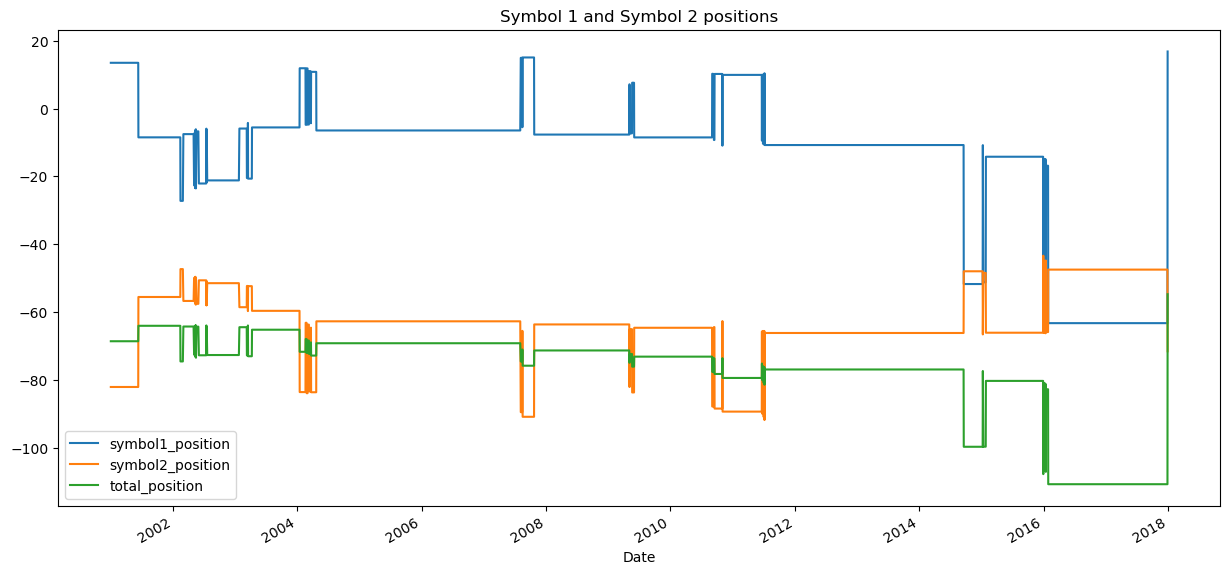

In [34]:
pair_correlation_trading_strategy['symbol1_buy'].head()


pair_correlation_trading_strategy['symbol1_position']=\
pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position']=\
pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot(figsize=(15,7))
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot(figsize=(15,7))

pair_correlation_trading_strategy['total_position']=\
pair_correlation_trading_strategy['symbol1_position']+pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['total_position'].cumsum().plot(figsize=(15,7))
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()

18. We replace `s1prices` with `s1positions` from the earlier code by taking into account the number of shares we want to allocate for the trading of this pair:

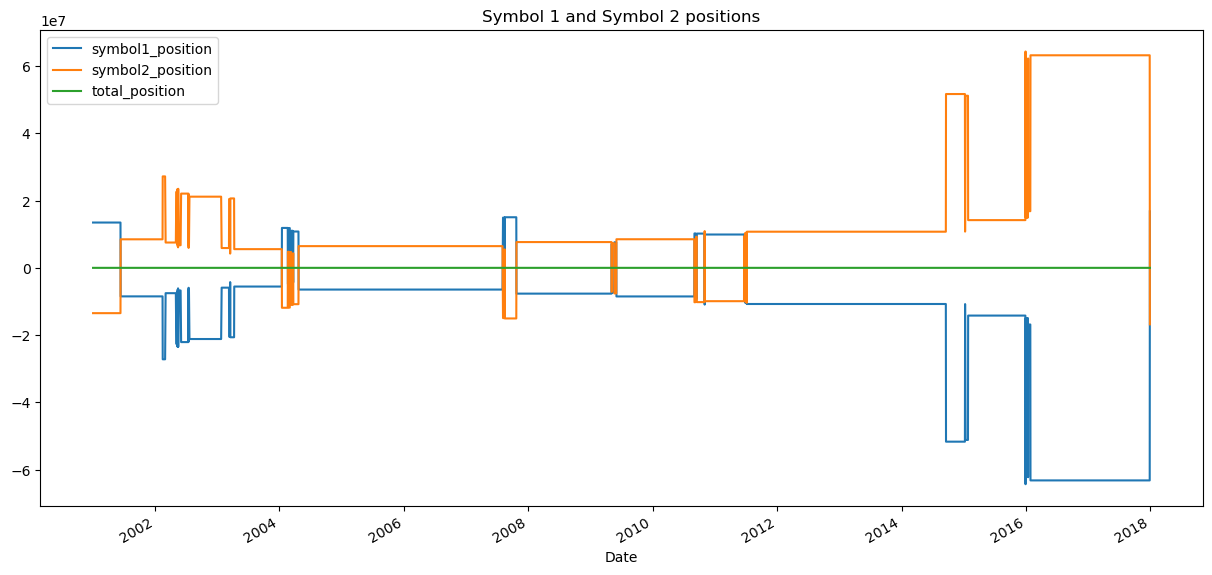

In [35]:
pair_correlation_trading_strategy['symbol1_price']=Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['delta']=np.zeros(len(Symbol1_prices))


position=0
s1_shares = 1000000
for i in range(len(Symbol1_prices)):
    s1positions= Symbol1_prices[i] * s1_shares
    s2positions= Symbol2_prices[i] * int(s1positions/Symbol2_prices[i])
    # print(Symbol1_prices[i],Symbol2_prices[i])
    delta_position=s1positions-s2positions
    if not position and symbol1_buy[i]!=0:
        pair_correlation_trading_strategy['symbol1_buy'][i]=s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i]=delta_position
        position=1
    elif not position and symbol1_sell[i]!=0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = -1
    elif position==-1 and (symbol1_sell[i]==0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        position = 0
    elif position==1 and (symbol1_buy[i] == 0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        position = 0


pair_correlation_trading_strategy['symbol1_position']=\
pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position']=\
pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot(figsize=(15,7))
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot(figsize=(15,7))

pair_correlation_trading_strategy['total_position']=\
pair_correlation_trading_strategy['symbol1_position']+pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['total_position'].cumsum().plot(figsize=(15,7))
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()

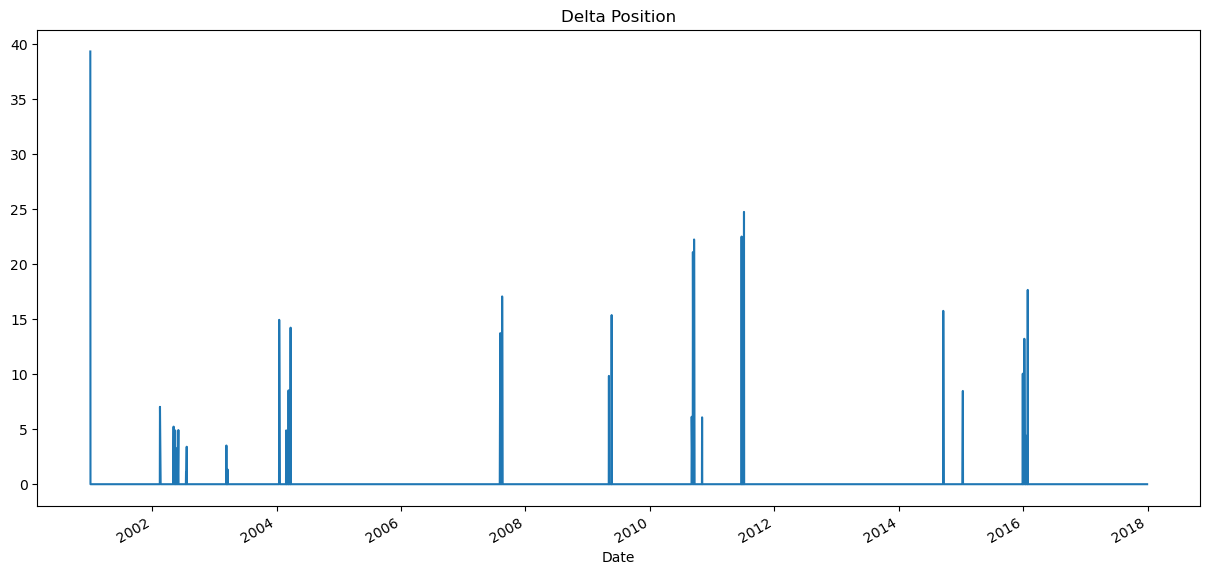

In [36]:
pair_correlation_trading_strategy['delta'].plot(figsize=(15,7))
plt.title("Delta Position")
plt.show()